# Large Rodent (Paca, Agouti, and Capybara) Classification

In this notebook, the concepts and codes from Chapter 2 of the book _Deep Learning for Coders with fastai and PyTorch_ are applied to build a large rodent (Paca, Agouti and Capybara) classifier.

This notebook applies concepts and code from Chapter 2 of _Deep Learning for Coders with fastai and PyTorch_ to build a classifier for three large South American rodents: pacas, agoutis, and capybaras.

Here's an overview of the steps involved:

**Dataset creation**

* Gather images of each rodent from online resources.
* Use a `DataLoader` to manage and split the data for training and validation.
* Apply data augmentation techniques to improve the model.

**Model training**
* Leverage a pre-trained model for efficient learning.
* Utilize the Fastai cleaner GUI for data cleaning.

**Web App development**
* Create a basic web app prototype to showcase the model's predictions.

Despite the limited dataset size (approximately 150 per rodent), the model demonstrates promissing performance.

**Interesting Facts about Pacas, Agoutis, and Capybaras:**

* These herbivorous rodents typically dwell near water sources.
* They share similar lifespans, ranging from 14 to 16 years.
* While pacas are solitary animals, agoutis live in small groups, and capybaras form large social groups.
* All three species contribute to seed dispersal by burying and forgetting food sources.

In [ ]:
!pip install voila==0.4.0

In [ ]:
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.4.0 OK


In [ ]:
!pip install -Uqq fastai duckduckgo_search

In [ ]:
from duckduckgo_search import DDGS
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastcore.all import *
from fastdownload import download_url
from ipywidgets import *
from urllib.error import HTTPError

In [ ]:
def search_images(keywords, max_images=150):
    print(f"Searching for {keywords}")
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

## Gathering data

In [ ]:
rodent_types = ['Cuniculus paca',
                'Dasyprocta punctata',
                'Hydrochoerus hydrochaeris'
                ]

path = Path('large_rodents')

for search_term in rodent_types:
    if search_term == 'Cuniculus paca':
      term = 'paca'
    elif search_term == 'Dasyprocta punctata':
      term = 'agouti'
    elif search_term == 'Hydrochoerus hydrochaeris':
      term = 'capybara'
    dest = (path/term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{search_term}'))
    resize_images(path/term, max_size=400, dest=path/term)

Searching for Cuniculus paca
Searching for Dasyprocta punctata
Searching for Hydrochoerus hydrochaeris


In [ ]:
# create a list containing image paths
fns = get_image_files(path)
fns

In [ ]:
# check for corrupted images and remove them
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [ ]:
!ls large_rodents/paca/ | wc -l

In [ ]:
!ls large_rodents/agouti/ | wc -l

In [ ]:
!ls large_rodents/capybara/ | wc -l

## Using DataLoaders

In [ ]:
# create a DataBlock object
rodents = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128, method='squish')])

In [ ]:
# load the data using a dataloader
dls = rodents.dataloaders(path, bs=32)

In [ ]:
dls.train.show_batch(max_n=8)

In [ ]:
dls.valid.show_batch(max_n=8)

## Data augmentation

In [ ]:
rodents = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_items = get_image_files,
        splitter = RandomSplitter(valid_pct=0.2, seed=4),
        get_y = parent_label,
        item_tfms = RandomResizedCrop(128, min_scale = 0.3),
        batch_tfms = aug_transforms(mult=2)
        )

In [ ]:
# load the data using a dataloader
dls = rodents.dataloaders(path, bs=32)

In [ ]:
dls.train.show_batch(max_n=8, unique=True)

## Model training

In [ ]:
# training the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

## Confusion matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
 # images with highest loss and correctly classified images with low confidence
 interp.plot_top_losses(6, nrows=1)

## Data cleaning

* Mark images for deletion
* Mark images for label change

After having marked a batch of images using the GUI for one label, the images must be deleted/moved. Then, the process must be repeated for other labels, otherwise changes will be lost.

After the data cleaning the data must be re-imported into the DataLoader and the model must be re-trained.

In [ ]:
# only return indices of items to change, doesn't make any changes
cleaner = ImageClassifierCleaner(learn, max_n=100)
cleaner

In [ ]:
for idx in cleaner.delete():
  print(cleaner.fns[idx])

large_rodents/paca/2183b344-2080-499e-8a49-9537efd37877.jpg
large_rodents/paca/4c070e80-8b1f-4352-a2f9-579a3de88e11.jpg
large_rodents/paca/6dcd832d-058a-4f8b-aab9-c6eadfba95d3.jpg
large_rodents/paca/e9e13c75-b63c-41e9-8376-860b8f8a7d1c.jpg
large_rodents/paca/984bf028-ec93-48dc-a852-1d28604b2b1d.jpg
large_rodents/paca/80d7d358-2aba-443f-b8cd-7eec52237b95.jpg
large_rodents/paca/ab55041b-0bd6-4cc1-b4cc-5205ba24b4d3.jpg


In [ ]:
for idx, category in cleaner.change():
  print(idx, category)

In [ ]:
# delete all images selected for deletion
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()

In [ ]:
# move selected images by the cleaner to a different category
#for idx, category in cleaner.change():
#  shutil.move(str(cleaner.fns[idx]), path/category)

In [ ]:
rodents = DataBlock(
        blocks = (ImageBlock, CategoryBlock),
        get_items = get_image_files,
        splitter = RandomSplitter(valid_pct=0.2, seed=4),
        get_y = parent_label,
        item_tfms = RandomResizedCrop(128, min_scale = 0.3),
        batch_tfms = aug_transforms(mult=2)
        )

In [ ]:
# load the data using a dataloader
dls = rodents.dataloaders(path, bs=32)

In [ ]:
# training the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

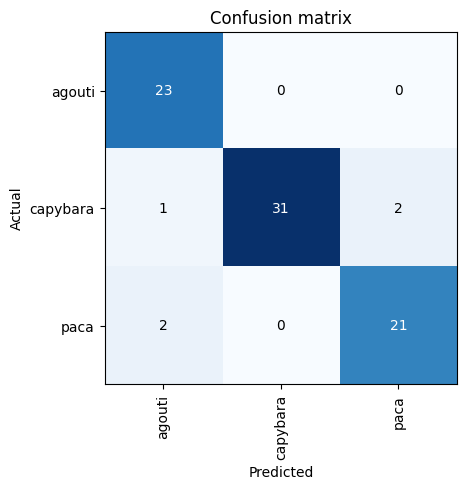

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Making predictions

In [ ]:
# save architecture and parameters of the trained model to export.pkl file
learn.export()

In [ ]:
# check saved model
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# create a inference learner from the saved model
learn_inf = load_learner(path/'export.pkl')

In [ ]:
# making prediction
learn_inf.predict('cutia.jpeg')

('agouti', tensor(0), tensor([9.9872e-01, 4.4424e-04, 8.3719e-04]))

In [ ]:
# access Dataloaders
learn_inf.dls.vocab

['agouti', 'capybara', 'paca']

## Building a notebook App from the model

In [ ]:
# create button to upload the image
upload_button = widgets.FileUpload()
upload_button

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(upload_button.data[-1])

In [ ]:
# create a button to display the image
output_button = widgets.Output()
output_button.clear_output()

with output_button:
  display(img.to_thumb(128, 128))
output_button

Output()

In [ ]:
# make prediction
pred, pred_idx, prob = learn_inf.predict(img)

In [ ]:
label_pred = widgets.Label()
label_pred.value = f'Prediction: {pred}, Probability:{prob[pred_idx]:.04f}'

In [ ]:
label_pred

Label(value='Prediction: agouti, Probability:0.9999')

In [ ]:
run_button = widgets.Button(description='Classify')
run_button

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
  img = PILImage.create(upload_button.data[-1])
  output_button.clear_output()
  with output_button:
      display(img.to_thumb(128,128))
  pred, pred_idx, prob = learn_inf.predict(img)
  label_pred.value = f'Prediction: {pred}, Probability: {prob[pred_idx]:.04f}'

In [ ]:
run_button.on_click(on_click_classify)

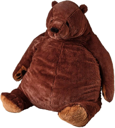

In [ ]:
VBox([widgets.Label('Select your large rodent!'),
      upload_button, run_button, output_button, label_pred
      ]
     )